In [1]:
import pandas as pd

# Load the datasets
customers_df = pd.read_csv('/content/Customers.csv')
transactions_df = pd.read_csv('/content/Transactions.csv')

# Merge the datasets on CustomerID
merged_df = pd.merge(transactions_df, customers_df, on='CustomerID', how='inner')

# Create new features for segmentation:
# Total Spend: Sum of TotalValue for each customer
customer_spend = merged_df.groupby('CustomerID')['TotalValue'].sum().reset_index()
customer_spend.rename(columns={'TotalValue': 'TotalSpend'}, inplace=True)

# Transaction Count: Number of transactions per customer
transaction_count = merged_df.groupby('CustomerID')['TransactionID'].count().reset_index()
transaction_count.rename(columns={'TransactionID': 'TransactionCount'}, inplace=True)

# Merge all features back to the customer dataset
customer_features = pd.merge(customers_df, customer_spend, on='CustomerID', how='left')
customer_features = pd.merge(customer_features, transaction_count, on='CustomerID', how='left')

# Handle any missing data (if any)
customer_features.fillna(0, inplace=True)

# Preview the final dataset
customer_features.head()


,CustomerID,CustomerName,Region,SignupDate,TotalSpend,TransactionCount
0,C0001,Lawrence Carroll,South America,2022-07-10,3354.52,5.0
1,C0002,Elizabeth Lutz,Asia,2022-02-13,1862.74,4.0
2,C0003,Michael Rivera,South America,2024-03-07,2725.38,4.0
3,C0004,Kathleen Rodriguez,South America,2022-10-09,5354.88,8.0
4,C0005,Laura Weber,Asia,2022-08-15,2034.24,3.0


In [2]:
# Calculate Average Transaction Value for each customer
customer_features['AvgTransactionValue'] = customer_features['TotalSpend'] / customer_features['TransactionCount']

# Optional: Add a feature for how long the customer has been active
customer_features['SignupYear'] = pd.to_datetime(customer_features['SignupDate']).dt.year
customer_features['YearsSinceSignup'] = 2025 - customer_features['SignupYear']

# Preview the final dataset with engineered features
customer_features.head()


,CustomerID,CustomerName,Region,SignupDate,TotalSpend,TransactionCount,AvgTransactionValue,SignupYear,YearsSinceSignup
0,C0001,Lawrence Carroll,South America,2022-07-10,3354.52,5.0,670.904,2022,3
1,C0002,Elizabeth Lutz,Asia,2022-02-13,1862.74,4.0,465.685,2022,3
2,C0003,Michael Rivera,South America,2024-03-07,2725.38,4.0,681.345,2024,1
3,C0004,Kathleen Rodriguez,South America,2022-10-09,5354.88,8.0,669.360,2022,3
4,C0005,Laura Weber,Asia,2022-08-15,2034.24,3.0,678.080,2022,3


In [27]:
from sklearn.preprocessing import MinMaxScaler, RobustScaler

# Try MinMax Scaling
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(customer_features[features_to_scale])


print(scaled_features)



[[0.31427402 0.45454545 0.47433644 1.        ]
 [0.17451402 0.36363636 0.30894039 1.        ]
 [0.25533195 0.36363636 0.48275135 0.        ]
 [0.50168121 0.72727273 0.47309205 1.        ]
 [0.1905813  0.27272727 0.48011993 1.        ]
 [0.39606722 0.36363636 0.78542347 0.        ]
 [0.24169491 0.27272727 0.62668981 1.        ]
 [0.40019318 0.90909091 0.27789201 0.        ]
 [0.08399016 0.27272727 0.17446646 0.5       ]
 [0.16091165 0.36363636 0.27968646 1.        ]
 [0.34945151 0.45454545 0.53485998 1.        ]
 [0.49009965 0.63636364 0.53592614 0.        ]
 [0.56217286 0.63636364 0.62449993 0.        ]
 [0.02985421 0.09090909 0.19044574 0.        ]
 [0.10844052 0.18181818 0.40005695 0.5       ]
 [0.36298175 0.45454545 0.55813901 0.        ]
 [0.44536986 0.72727273 0.41253909 0.5       ]
 [0.4479959  0.45454545 0.70440747 0.        ]
 [0.20478233 0.54545455 0.22723194 0.5       ]
 [0.08641758 0.09090909 0.67703744 0.        ]
 [0.50777459 0.72727273 0.47964442 0.5       ]
 [0.4361183  

In [29]:

scaled_df.isnull().sum()


,0
TotalSpend,0
TransactionCount,0
AvgTransactionValue,0
YearsSinceSignup,0


In [30]:
from sklearn.impute import SimpleImputer

# Impute missing values with the mean of the respective columns
imputer = SimpleImputer(strategy='mean')
scaled_df = pd.DataFrame(imputer.fit_transform(scaled_df), columns=scaled_df.columns)


In [33]:
from sklearn.decomposition import PCA

# Reduce dimensions to 2D for visualization
pca = PCA(n_components=2)
pca_components = pca.fit_transform(scaled_df)


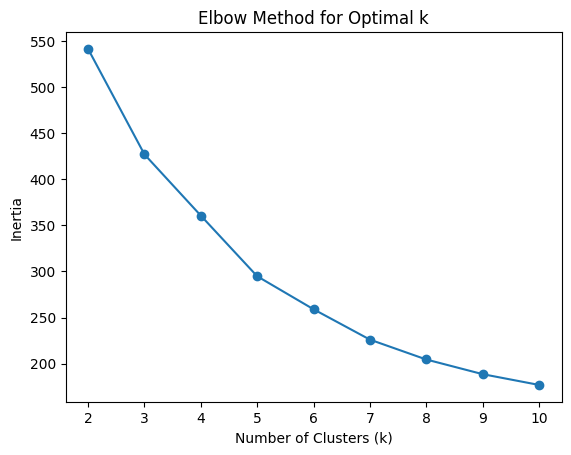

In [36]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

inertia = []

for k in range(2, 11):

    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10, max_iter=300)

    # Fit the KMeans model to your data
    kmeans.fit(scaled_df)

    # Append the inertia value to the list
    inertia.append(kmeans.inertia_)

# Now plot the inertia values against the cluster numbers
plt.plot(range(2, 11), inertia, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.show()


In [66]:
from sklearn.metrics import davies_bouldin_score

# Calculate Davies-Bouldin Index for the final clustering (let's assume k=4 based on your elbow plot)
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10, max_iter=300)
kmeans.fit(scaled_df)
cluster_labels = kmeans.labels_

# Calculate DB Index
db_index = davies_bouldin_score(scaled_df, cluster_labels)
print(f"DB Index: {db_index}")


DB Index: 0.8246867889870906


In [67]:
from sklearn.metrics import silhouette_score

# Calculate Silhouette Score for the final clustering
sil_score = silhouette_score(scaled_df, cluster_labels)
print(f"Silhouette Score: {sil_score}")


Silhouette Score: 0.4532147990263876


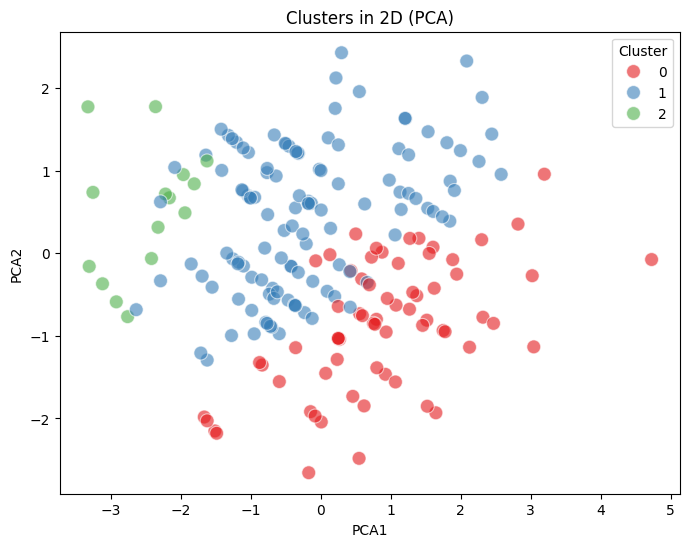

In [68]:
from sklearn.decomposition import PCA

# Reduce the data to 2D using PCA for visualization
pca = PCA(n_components=2)
pca_components = pca.fit_transform(scaled_df.drop('Cluster', axis=1))

# Create a dataframe with the PCA components and cluster labels
pca_df = pd.DataFrame(pca_components, columns=['PCA1', 'PCA2'])
pca_df['Cluster'] = cluster_labels

# Plot the clusters in 2D
plt.figure(figsize=(8, 6))
sns.scatterplot(x='PCA1', y='PCA2', hue='Cluster', data=pca_df, palette='Set1', s=100, alpha=0.6)
plt.title('Clusters in 2D (PCA)')
plt.show()
